In [1]:
import numpy as np

# --- STEP 1: Model Problem Definition ---
# Equation: u''(x) = f(x), f(x) = 1
# Interval: [0, 1], h = 0.2
L = 1.0
num_elements = 5
h = L / num_elements
nodes = np.linspace(0, L, num_elements + 1)  # [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# --- STEP 2: Local Calculation ---
# Local Stiffness Matrix K^e = (1/h) * [[1, -1], [-1, 1]]
ke = (1/h) * np.array([[1, -1], 
                       [-1, 1]])

# Local Load Vector F^e = -[h/2, h/2] (for f(x) = 1)
fe = -np.array([h/2, h/2])

print(f"Local Stiffness Matrix K^e:\n{ke}")
print(f"Local Load Vector F^e: {fe}\n")

# --- STEP 3: Global Assembly ---
size = num_elements + 1
K_global = np.zeros((size, size))
F_global = np.zeros(size)

for e in range(num_elements):
    # Map local nodes to global indices
    idx = [e, e + 1]
    
    # Assembly: Add local contributions to global matrix/vector
    K_global[np.ix_(idx, idx)] += ke
    F_global[idx] += fe

print(f"Global Stiffness Matrix K:\n{K_global}")
print(f"Global Load Vector F: {F_global}\n")

# --- STEP 4: Boundary Conditions ---
# u(0) = 0, u(1) = 0
# We solve for internal nodes u1, u2, u3, u4 (indices 1 to 4)
K_reduced = K_global[1:5, 1:5]
F_reduced = F_global[1:5]

# --- STEP 5: Solve ---
u_internal = np.linalg.solve(K_reduced, F_reduced)

# Combine with boundary conditions for full solution vector U
U = np.zeros(size)
U[1:5] = u_internal

print("Final Parameters U:")
for i, val in enumerate(U):
    print(f"u_{i} = {val:.2f}")

Local Stiffness Matrix K^e:
[[ 5. -5.]
 [-5.  5.]]
Local Load Vector F^e: [-0.1 -0.1]

Global Stiffness Matrix K:
[[ 5. -5.  0.  0.  0.  0.]
 [-5. 10. -5.  0.  0.  0.]
 [ 0. -5. 10. -5.  0.  0.]
 [ 0.  0. -5. 10. -5.  0.]
 [ 0.  0.  0. -5. 10. -5.]
 [ 0.  0.  0.  0. -5.  5.]]
Global Load Vector F: [-0.1 -0.2 -0.2 -0.2 -0.2 -0.1]

Final Parameters U:
u_0 = 0.00
u_1 = -0.08
u_2 = -0.12
u_3 = -0.12
u_4 = -0.08
u_5 = 0.00


# Mapping to the Reference Element

In [2]:
import numpy as np

# --- STEP 8.1: Reference Element Definitions ---
h = 0.2
jacobian = h / 2  # J = dx/dxi = 0.1

# Reference Shape Function derivatives dN/dxi
def dN_dxi():
    return np.array([-0.5, 0.5])

# Reference Shape Functions at xi
def N_xi(xi):
    return np.array([(1 - xi)/2, (1 + xi)/2])

# --- STEP 8.3: Gaussian Quadrature (1-point) ---
gauss_point = 0.0
gauss_weight = 2.0

# --- STEP 8.4: Computation of K^e and F^e ---
# K_ij^e = integral[ (dN_i/dxi * 1/J) * (dN_j/dxi * 1/J) * J * dxi ]
# Simplified: K_ij^e = (dN_i/dxi * dN_j/dxi * 1/J) * weight
B = dN_dxi() # [-0.5, 0.5]
ke_map = np.outer(B, B) * (1/jacobian) * gauss_weight

# F_i^e = - integral[ f(x) * N_i(xi) * J * dxi ]
# Simplified: F_i^e = -(1 * N_i(0) * J) * weight
fe_map = -(1.0 * N_xi(gauss_point) * jacobian) * gauss_weight

print(f"Mapped Local Stiffness K^e:\n{ke_map}")
print(f"Mapped Local Load F^e: {fe_map}\n")

# --- Final parameters check ---
# Solving the reduced system same as Script 1
K_sys = np.array([[10, -5,  0,  0],
                  [-5, 10, -5,  0],
                  [ 0, -5, 10, -5],
                  [ 0,  0, -5, 10]])

F_sys = np.array([-0.2, -0.2, -0.2, -0.2])
u_sol = np.linalg.solve(K_sys, F_sys)

print(f"Computed Internal Parameters: {u_sol}")

Mapped Local Stiffness K^e:
[[ 5. -5.]
 [-5.  5.]]
Mapped Local Load F^e: [-0.1 -0.1]

Computed Internal Parameters: [-0.08 -0.12 -0.12 -0.08]


# Level 4: Complex Multi-Physics Simulation
## Steady-State Induction Heating with Gaussian Source

In this final step, we transition from simple constant source terms to a physically realistic **Gaussian Induction Source**. This simulates an induction coil focused on a specific region of a 1D rod.

### 1. Governing Physical Model
The temperature distribution $u(x)$ along a one-dimensional rod is governed by the steady-state heat conduction equation:

$$-k \frac{d^2u}{dx^2} = f(x), \quad x \in (0, 1)$$

Where:
* $k$: Thermal conductivity (ability of the rod to conduct heat).
* $u(x)$: Temperature at any point $x$.
* $f(x)$: The internal heat generation rate per unit length.

### 2. The Complex Source: Gaussian Induction
To model a concentrated heating zone, we define $f(x)$ as a Gaussian function:

$$f(x) = A \cdot \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)$$

**Parameters:**
* $A$ (**Amplitude**): The intensity of the induction power.
* $\mu$ (**Mean**): The physical center of the induction coil.
* $\sigma$ (**Sigma**): The width of the heating zone (standard deviation).



### 3. Boundary Conditions (Dirichlet)
We assume the ends of the rod are submerged in a temperature-controlled environment:
* $u(0) = 20$ (Fixed temperature at left end)
* $u(1) = 20$ (Fixed temperature at right end)

---

### 4. Finite Element Formulation
Following the principles of the Weak Form, we multiply by a test function $v(x)$ and integrate over the domain $\Omega = [0, 1]$. Using integration by parts:

$$\int_{0}^{1} k u'(x) v'(x) dx = \int_{0}^{1} f(x) v(x) dx$$

#### Local Element Matrices
For a linear element $e$ of length $h$, the matrices are calculated as:

**Stiffness Matrix ($\mathbf{K}^e$):**
$$\mathbf{K}^e = \frac{k}{h} \begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix}$$

**Load Vector ($\mathbf{F}^e$):**
Because $f(x)$ is a complex Gaussian function, the integral for the load vector must be solved numerically or via mapping:
$$\mathbf{F}^e = \int_{x_e}^{x_{e+1}} \left[ A \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right) \right] \begin{bmatrix} N_0(x) \\ N_1(x) \end{bmatrix} dx$$

---

### 5. Implementation Strategy
To solve this in Python:
1. **Global Assembly:** Loop through $n$ elements and add local $\mathbf{K}^e$ and $\mathbf{F}^e$ to global structures.
2. **Numerical Integration:** Use Simpson's Rule or Gaussian Quadrature to handle the exponential source term.
3. **Partitioning:** Modify the global system to account for the non-zero boundary conditions ($u=20$).
4. **Solve:** Perform the matrix inversion $\mathbf{U} = \mathbf{K}^{-1} \mathbf{F}$.

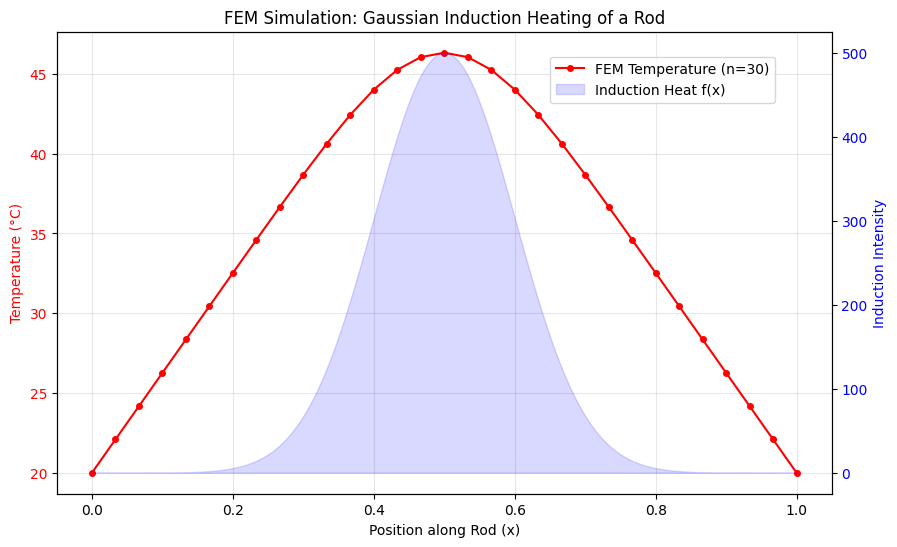

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

"""
GOVERNING PDE: -k * u''(x) = f(x)
Complex Source f(x): Gaussian Induction Heating
f(x) = Amplitude * exp(-(x - mean)^2 / (2 * sigma^2))
Boundary Conditions: u(0) = 20, u(1) = 20 (Fixed end temperatures)
"""

def solve_induction_fem(num_elements, amp=500, mean=0.5, sigma=0.1):
    # --- 1. Parameters & Geometry ---
    L = 1.0            # Length of rod
    k = 1.0            # Thermal conductivity
    u_boundary = 20.0  # Ambient temperature at ends
    h = L / num_elements
    nodes = np.linspace(0, L, num_elements + 1)
    
    size = num_elements + 1
    K_global = np.zeros((size, size))
    F_global = np.zeros(size)

    # --- 2. Define the Induction Function f(x) ---
    def f_induction(x):
        return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

    # --- 3. Local Element Formulation & Assembly ---
    for e in range(num_elements):
        idx = [e, e+1]
        x_left, x_right = nodes[e], nodes[e+1]
        
        # Local Stiffness Matrix: k/h * [[1, -1], [-1, 1]]
        ke = (k/h) * np.array([[1, -1], [-1, 1]])
        
        # Local Load Vector: integral(f(x) * N_i(x)) dx
        # Since f(x) is complex, we use Simpson's rule for local integration
        x_local = np.linspace(x_left, x_right, 11)
        f_local = f_induction(x_local)
        
        # Local shape functions N0 and N1 evaluated on local grid
        N0 = (x_right - x_local) / h
        N1 = (x_local - x_left) / h
        
        fe = np.array([
            simpson(y=f_local * N0, x=x_local),
            simpson(y=f_local * N1, x=x_local)
        ])
        
        # Assemble into Global Matrix and Vector
        K_global[np.ix_(idx, idx)] += ke
        F_global[idx] += fe

    # --- 4. Apply Dirichlet Boundary Conditions (Non-Zero) ---
    # We solve for interior nodes, but adjust F based on u(0) and u(1)
    F_global[1:-1] -= K_global[1:-1, 0] * u_boundary
    F_global[1:-1] -= K_global[1:-1, -1] * u_boundary
    
    K_interior = K_global[1:-1, 1:-1]
    F_interior = F_global[1:-1]
    
    u = np.full(size, u_boundary) # Fill with BC value
    u[1:-1] = np.linalg.solve(K_interior, F_interior)
    
    return nodes, u, f_induction

# --- 5. Execution and Plotting ---
n_el = 30
nodes, u_fem, f_func = solve_induction_fem(n_el)

x_fine = np.linspace(0, 1, 500)
heat_source = f_func(x_fine)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Temperature
ax1.plot(nodes, u_fem, 'ro-', label=f'FEM Temperature (n={n_el})', markersize=4)
ax1.set_xlabel('Position along Rod (x)')
ax1.set_ylabel('Temperature (°C)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, alpha=0.3)

# Plot Heat Source (The Gaussian)
ax2 = ax1.twinx()
ax2.fill_between(x_fine, heat_source, color='blue', alpha=0.15, label='Induction Heat f(x)')
ax2.set_ylabel('Induction Intensity', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('FEM Simulation: Gaussian Induction Heating of a Rod')
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
plt.show()

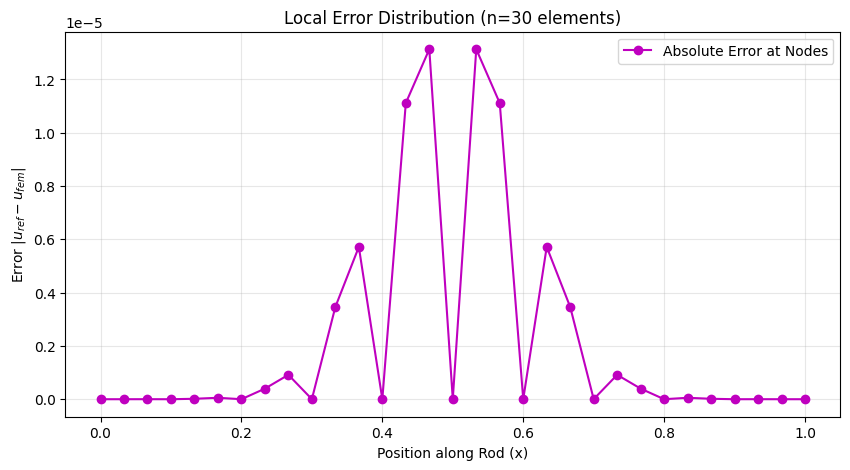

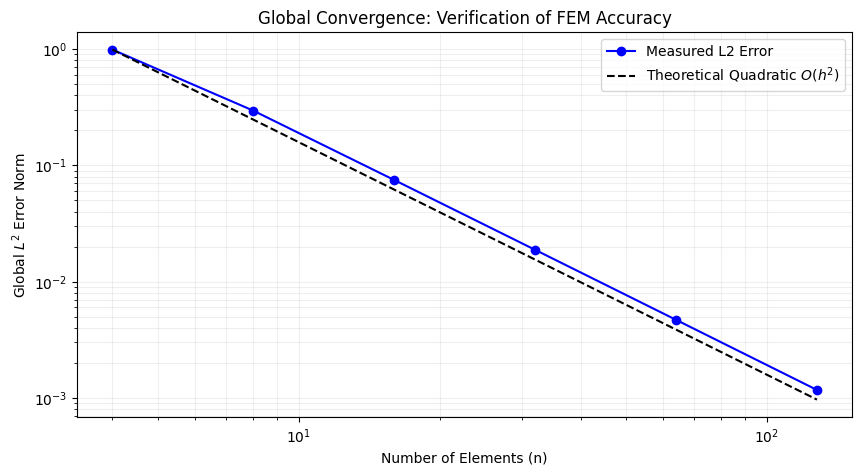

Mesh Step (h)   | L2 Error        | Rate      
0.1250          | 2.950037e-01    | 1.74      
0.0625          | 7.474226e-02    | 1.98      
0.0312          | 1.874191e-02    | 2.00      
0.0156          | 4.686268e-03    | 2.00      
0.0078          | 1.168855e-03    | 2.00      


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

def solve_induction_fem(num_elements, amp=500, mean=0.5, sigma=0.1):
    """Original FEM solver for Gaussian Induction Heating"""
    L, k, u_boundary = 1.0, 1.0, 20.0
    h = L / num_elements
    nodes = np.linspace(0, L, num_elements + 1)
    size = num_elements + 1
    K_global = np.zeros((size, size))
    F_global = np.zeros(size)

    f_induction = lambda x: amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

    for e in range(num_elements):
        idx = [e, e+1]
        x_left, x_right = nodes[e], nodes[e+1]
        ke = (k/h) * np.array([[1, -1], [-1, 1]])
        
        # Local numerical integration for Gaussian source
        x_local = np.linspace(x_left, x_right, 21)
        f_local = f_induction(x_local)
        N0 = (x_right - x_local) / h
        N1 = (x_local - x_left) / h
        
        fe = np.array([
            simpson(y=f_local * N0, x=x_local),
            simpson(y=f_local * N1, x=x_local)
        ])
        
        K_global[np.ix_(idx, idx)] += ke
        F_global[idx] += fe

    # Boundary Conditions
    F_global[1:-1] -= K_global[1:-1, 0] * u_boundary
    F_global[1:-1] -= K_global[1:-1, -1] * u_boundary
    u = np.full(size, u_boundary)
    u[1:-1] = np.linalg.solve(K_global[1:-1, 1:-1], F_global[1:-1])
    return nodes, u, f_induction

# --- ERROR ANALYSIS EXTENSION ---

# 1. Generate High-Resolution Reference Solution
nodes_ref, u_ref, f_func = solve_induction_fem(2000)

def calculate_errors(n, nodes_ref, u_ref):
    """Calculates local nodal error and global L2 error for a given mesh size n"""
    nodes, u, _ = solve_induction_fem(n)
    
    # Interpolate reference solution to compare at FEM nodes
    u_ref_nodal = np.interp(nodes, nodes_ref, u_ref)
    local_nodal_error = np.abs(u_ref_nodal - u)
    
    # Calculate Global L2 Error Norm: sqrt(integral[ (u_ref - u_fem)^2 dx ])
    x_eval = np.linspace(0, 1, 5000) # High-res grid for integration
    u_ref_eval = np.interp(x_eval, nodes_ref, u_ref)
    u_fem_eval = np.interp(x_eval, nodes, u)
    l2_error = np.sqrt(simpson(y=(u_ref_eval - u_fem_eval)**2, x=x_eval))
    
    return nodes, u, local_nodal_error, l2_error

# 2. Local Error Analysis for n=30
n_plot = 30
nodes_p, u_p, local_err_p, _ = calculate_errors(n_plot, nodes_ref, u_ref)

# 3. Global Convergence Study
mesh_sizes = [4, 8, 16, 32, 64, 128]
global_errors = []
for n in mesh_sizes:
    _, _, _, err = calculate_errors(n, nodes_ref, u_ref)
    global_errors.append(err)

# --- PLOTTING ---

# Graph 1: Local Error Distribution (Absolute Nodal Error)
plt.figure(figsize=(10, 5))
plt.plot(nodes_p, local_err_p, 'm-o', label='Absolute Error at Nodes')
plt.xlabel('Position along Rod (x)')
plt.ylabel('Error $|u_{ref} - u_{fem}|$')
plt.title(f'Local Error Distribution (n={n_plot} elements)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Continuing from the previous block...

# Graph 2: Global Convergence (Log-Log Plot)
plt.figure(figsize=(10, 5))
h_vals = 1.0 / np.array(mesh_sizes)
plt.loglog(mesh_sizes, global_errors, 'bo-', label='Measured L2 Error')

# Theoretical O(h^2) slope reference
# We align this line with our first error point to see if the slopes match
ref_slope = (1.0/np.array(mesh_sizes))**2 * (global_errors[0] * mesh_sizes[0]**2)
plt.loglog(mesh_sizes, ref_slope, 'k--', label=r'Theoretical Quadratic $O(h^2)$')

plt.xlabel('Number of Elements (n)')
plt.ylabel('Global $L^2$ Error Norm')
plt.title('Global Convergence: Verification of FEM Accuracy')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

# Print the numerical convergence rates
print(f"{'Mesh Step (h)':<15} | {'L2 Error':<15} | {'Rate':<10}")
for i in range(1, len(global_errors)):
    h_prev, h_curr = 1/mesh_sizes[i-1], 1/mesh_sizes[i]
    rate = np.log(global_errors[i]/global_errors[i-1]) / np.log(h_curr/h_prev)
    print(f"{h_curr:<15.4f} | {global_errors[i]:<15.6e} | {rate:<10.2f}")
# Graph